In [1]:
!pip install evaluate transformers[torch] torchaudio wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 165.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 227.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 221.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 216.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9


In [45]:
import json
import torch
import wandb
import random
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seaborn import heatmap
from collections import Counter 
from datasets import DatasetDict
from torch import tensor, Tensor
from torch.nn import Module, Linear, LayerNorm
from torch.nn.functional import softmax
from torchaudio import transforms
from torch.nn import CrossEntropyLoss
from sklearn.metrics import confusion_matrix
from torch.nn.functional import interpolate, pad
from transformers.trainer_utils import EvalPrediction
from sklearn.utils.class_weight import compute_class_weight
from transformers import ASTFeatureExtractor, ASTConfig, ASTForAudioClassification, TrainingArguments, Trainer

In [3]:
%env WANDB_PROJECT=genre_classification

env: WANDB_PROJECT=genre_classification


In [ ]:
wandb.login(key="...", host="https://wandb.justinkonratt.com")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for wandb.justinkonratt.com to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: codesdowork to https://wandb.justinkonratt.com. Use `wandb login --relogin` to force relogin


True

In [5]:
with open("./dataset/genres.json", "r", encoding="utf-8") as f:
    genres = json.load(f)
genres

['Bad',
 'Bassy',
 'Big Room',
 'Bounce',
 'Chill',
 'Chill Beat',
 'Chillstep',
 'Classic',
 'Country',
 'Dance Pop',
 'Deep House',
 'Drum and Bass',
 'Dubstep',
 'EDM',
 'Electro',
 'Electro House',
 'Emotional',
 'Epic',
 'Folk',
 'Frenchcore',
 'Glitch Hop',
 'God',
 'Groove',
 'Hands Up',
 'Hardcore',
 'Hardstyle',
 'Harp',
 'Hip-Hop',
 'Historic',
 'Latino',
 'Lo-Fi',
 'Lounge',
 'Malle',
 'Minimal',
 'Motivation',
 'Oldschool Techno',
 'Orchestra Pop',
 'Orchestral Electro',
 'Psy',
 'Rap',
 'Rock',
 'Slow',
 'Techno',
 'Tekk',
 'Weihnachten']

In [6]:
preprocessed_dataset = DatasetDict.load_from_disk("./dataset/music_lib")
preprocessed_dataset

Loading dataset from disk:   0%|          | 0/21 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 19312
    })
    validate: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 2760
    })
    test: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 5519
    })
})

In [7]:
pretrained_model = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model)

model_input_name = feature_extractor.model_input_names[0]
labels_name = "labels"
paths_name = "paths"

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [8]:
config = ASTConfig.from_pretrained(pretrained_model)
config.num_labels = len(genres)
config.label2id = { genre: idx for idx, genre in enumerate(genres) }
config.id2label = { idx: genre for idx, genre in enumerate(genres) }
config.hidden_dropout_prob = 0.00
config.attention_probs_dropout_prob = 0.00

model = ASTForAudioClassification.from_pretrained(pretrained_model, config=config, ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model.classifier

ASTMLPHead(
  (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dense): Linear(in_features=768, out_features=45, bias=True)
)

In [59]:
class TemporalAttention(Module):
    def __init__(self):
        super(TemporalAttention, self).__init__()
        self.attention_weights = Linear(config.hidden_size, 1)

    def forward(self, cls_tokens):
        scores = self.attention_weights(cls_tokens)
        attention_weights = softmax(scores, dim=1)
        return torch.sum(attention_weights * cls_tokens, dim=0)

class AggregateSnipptesClassifier(Module):
    def __init__(self):
        super(AggregateSnipptesClassifier, self).__init__()
        self.layernorm = LayerNorm(normalized_shape=(config.hidden_size,), eps=1e-12, elementwise_affine=True)
        self.attention = TemporalAttention()
        self.classifier = Linear(in_features=config.hidden_size, out_features=config.num_labels, bias=True)

    def forward(self, cls_tokens):
        normalized_cls_tokens = self.layernorm(cls_tokens)
        song_cls_token = self.attention(normalized_cls_tokens)
        return self.classifier(song_cls_token)

class ASTSnippetModel(Module):
    def __init__(self):
        super(ASTSnippetModel, self).__init__()
        self.model = ASTForAudioClassification.from_pretrained(pretrained_model, config=config, ignore_mismatched_sizes=True)
        self.classifier = AggregateSnipptesClassifier()
    
model.classifier = AggregateSnipptesClassifier()

In [60]:
model_input = tensor(preprocessed_dataset["train"][0:6]["input_values"])
output = model(model_input).logits
output.shape

torch.Size([45])

In [7]:
def calc_aggregated_accuracy(predictions: Tensor, labels: Tensor):
    v_score = 0
    w_score = 0
    a_score = 0
    m_score = 0

    songs_per_genre = [0 for _ in range(len(genres))]
    correctly_predicted_per_genre = [0 for _ in range(len(genres))]

    eval_subset = None
    for subset in preprocessed_dataset.values():
        if len(subset) == predictions.shape[0]:
            eval_subset = subset

    true_labels = []
    predicted_labels = []

    entries_per_song = list(Counter(eval_subset[paths_name]).values())
    song_count = len(entries_per_song)
    start_idx = 0
    for song_entries in entries_per_song:
        label = labels[start_idx]
        true_labels.append(label)
        songs_per_genre[label] += 1
        song_logits = predictions[start_idx:start_idx + song_entries,:]
        start_idx += song_entries

        # voting
        v_pred = song_logits.argmax(dim=1).mode().values.item()
        if v_pred == label:
            v_score += 1

        # weighting
        confidence = song_logits.softmax(dim=1).max(dim=1).values
        weighted_logits = (song_logits.T * confidence).T
        w_pred = weighted_logits.mean(dim=0).argmax().item()
        if w_pred == label:
            w_score += 1

        # average
        a_pred = song_logits.mean(dim=0).argmax().item()
        predicted_labels.append(a_pred)
        if a_pred == label:
            a_score += 1
            correctly_predicted_per_genre[label] += 1

        # max
        m_pred = song_logits.max(dim=0).values.argmax().item()
        if m_pred == label:
            m_score += 1

    cm = confusion_matrix(true_labels, predicted_labels)
    cm_normalized_row = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    heatmap(cm_normalized_row, xticklabels=genres, yticklabels=genres)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    threshold = 0.1
    confusions = []
    for i in range(cm_normalized_row.shape[0]):
        for j in range(cm_normalized_row.shape[1]):
            if i != j and cm_normalized_row[i, j] > threshold:
                confusions.append((genres[i], genres[j], cm_normalized_row[i, j]))
    confusion_df = pd.DataFrame(confusions, columns=['True Class', 'Predicted Class', 'Confusion Value'])
    confusion_df = confusion_df.sort_values(by='Confusion Value', ascending=False)
    print(confusion_df)

    return {
        "voting_score": v_score / song_count,
        "weighting_score": w_score / song_count,
        "mean_pooling_score": a_score / song_count,
        "max_pooling_score": m_score / song_count,
        **{ f"{genre}_a_accuracy": correctly_predicted_per_genre[idx] / songs_per_genre[idx] for idx, genre in enumerate(genres) }
    }

accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")

AVERAGE = "macro" if config.num_labels > 2 else "binary"

def compute_metrics(eval_pred: EvalPrediction):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=1)
    metrics = accuracy.compute(predictions=predictions, references=labels)
    metrics.update(precision.compute(predictions=predictions, references=labels, average=AVERAGE))
    metrics.update(recall.compute(predictions=predictions, references=labels, average=AVERAGE))
    metrics.update(f1.compute(predictions=predictions, references=labels, average=AVERAGE))
    metrics.update(calc_aggregated_accuracy(tensor(logits), tensor(labels)))
    return metrics

In [8]:
def visualize_spectrum(specs, size=(10,6), cols=1, rows=1):
    plt.figure(figsize=size)
    for idx, spec in enumerate(specs):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(spec.T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label="Amplitude")
        plt.xlabel("Time Frames")
        plt.ylabel("Frequency Bins")
        plt.tight_layout()
    plt.tight_layout()
    plt.show()

In [9]:
class SpecAugmentPipeline:
    def __init__(
            self,
            p=0.5,
            effects_p=0.5,
            time_mask_param=30,
            freq_mask_param=20,
            noise_level=0.05,
            stretch_range=(0.97, 1.03),
            shift_range=3,
            amplitude_range=(0.8, 1.2)
    ):
        self.p = p
        self.effects_p = effects_p
        self.time_mask = transforms.TimeMasking(time_mask_param)
        self.freq_mask = transforms.FrequencyMasking(freq_mask_param)
        self.noise_level = noise_level
        self.stretch_range = stretch_range
        self.shift_range = shift_range
        self.amplitude_range = amplitude_range

    def add_noise(self, spec):
        return spec + torch.randn_like(spec) * self.noise_level
    
    def time_stretch(self, spec):
        spec = spec.unsqueeze(0)
        factor = random.uniform(*self.stretch_range)
        new_steps = int(spec.size(-1) * factor)
        new_spec = interpolate(spec, (spec.size(-2), new_steps), mode="bilinear", align_corners=False).squeeze(0)
        return new_spec.resize_(spec.size(-3), spec.size(-2), spec.size(-1)) if factor >= 1 else pad(new_spec, (0, spec.size(-1) - new_steps))

    def frequency_shift(self, spec):
        shift = random.randint(-self.shift_range, self.shift_range)
        return torch.roll(spec, shifts=shift, dims=-2)

    def amplitude_scaling(self, spec):
        return spec * random.uniform(*self.amplitude_range)

    def __call__(self, spec):
        if random.random() >= self.p:
            return spec
        
        spec = spec.transpose(-1, -2)
        if random.random() < self.effects_p:
            spec = self.time_mask(spec)
        
        if random.random() < self.effects_p:
            spec = self.freq_mask(spec)

        if random.random() < self.effects_p:
            spec = self.add_noise(spec)

        # bad loss behavior
        # if random.random() < self.effects_p:
        #     spec = self.time_stretch(spec)

        if random.random() < self.effects_p:
            spec = self.frequency_shift(spec)

        if random.random() < self.effects_p:
            spec = self.amplitude_scaling(spec)

        return spec.transpose(-1, -2)

In [10]:
aug_pipe = SpecAugmentPipeline(p=1)
def augmentation(sample):
    if model_input_name in sample:
        sample[model_input_name] = aug_pipe(tensor(sample[model_input_name]))
    return sample

preprocessed_dataset["train"].set_transform(augmentation)

In [49]:
labels = preprocessed_dataset["train"][labels_name]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float, device="cuda")
class_weights

tensor([ 0.3374,  4.2074,  1.7881,  0.6623, 14.3052,  4.7684,  3.2512,  1.2548,
         1.1353,  4.7684,  2.7510,  2.1675,  2.8610,  1.9868,  0.5502,  0.9170,
         4.4704,  8.9407, 17.8815,  1.5549,  3.2512,  5.1090,  1.0074,  0.0744,
         0.6562,  0.4615, 17.8815,  3.4060,  5.9605,  2.5545,  8.9407,  0.9843,
         1.1353,  2.6491,  0.8941,  0.2630,  4.4704,  3.4060,  1.3495,  1.2548,
         0.5863,  5.9605,  2.6491,  3.5763,  4.7684], device='cuda:0')

In [50]:
def weighted_loss_func(outputs, labels, num_items_in_batch):
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
    return loss_fct(logits, labels)

In [11]:
batch_size = 64
devices = 1
warmup_epochs = 0.5

training_args = TrainingArguments(
    output_dir="./runs/ast_classifier",
    report_to="wandb",
    run_name="new_ds_2_lower_lr",
    learning_rate=5e-5,
    weight_decay=0.00,
    warmup_steps=round(len(preprocessed_dataset["train"]) / batch_size * warmup_epochs),
    push_to_hub=False,
    num_train_epochs=5,
    per_device_train_batch_size=batch_size // devices,
    per_device_eval_batch_size=batch_size // devices,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mean_pooling_score",
    greater_is_better=True,
    logging_strategy="steps",
    logging_steps=1,
    fp16=True,
    save_total_limit=3
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["validate"],
    compute_metrics=compute_metrics,
    # compute_loss_func=weighted_loss_func
)

In [ ]:
trainer.train()

./runs/ast_classifier/checkpoint-2416


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


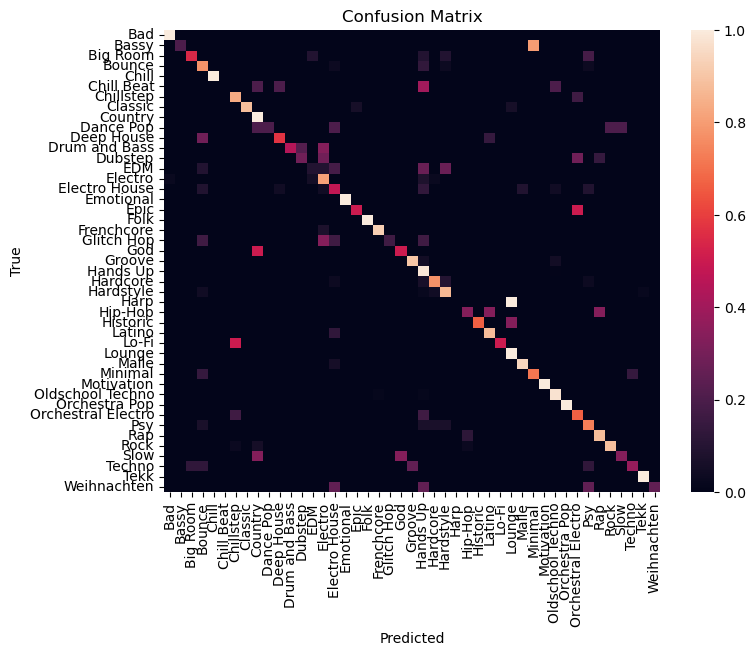

            True Class     Predicted Class  Confusion Value
29                Harp              Lounge         1.000000
0                Bassy             Minimal         0.800000
34               Lo-Fi           Chillstep         0.500000
23                Epic  Orchestral Electro         0.500000
28                 God             Country         0.500000
5           Chill Beat            Hands Up         0.400000
15       Drum and Bass             Electro         0.333333
31             Hip-Hop                 Rap         0.333333
25          Glitch Hop             Electro         0.333333
30             Hip-Hop              Latino         0.333333
32            Historic              Lounge         0.333333
41                Slow                 God         0.333333
40                Slow             Country         0.333333
12          Deep House              Bounce         0.285714
17             Dubstep  Orchestral Electro         0.285714
16             Dubstep             Elect

eval/Bad_a_accuracy,▁▁▁▁▁▁▁▁▁▁
eval/Bassy_a_accuracy,▁▁████████
eval/Big Room_a_accuracy,▁▃▆▆▃▃▃▅█▅
eval/Bounce_a_accuracy,▁█▅▅▆██▇▆▆
eval/Chill Beat_a_accuracy,▁▁▁▁▁▁▁▁▁▁
eval/Chill_a_accuracy,▁▁▁▁▁▁▁▁▁▁
eval/Chillstep_a_accuracy,▁▁▁▁▁▁▁▁▁▁
eval/Classic_a_accuracy,▁▁████████
eval/Country_a_accuracy,████▁█████
eval/Dance Pop_a_accuracy,▁▁▁▁▁▁▁▁▁▁
eval/Deep House_a_accuracy,▁▁████████


In [28]:
print(trainer.state.best_model_checkpoint)
results = trainer.evaluate(preprocessed_dataset["test"], metric_key_prefix="test")
print(results)

wandb.finish()